In [1]:
import os
import glob
import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image

In [5]:
file_names = np.array(glob.glob('/mnt/c/Users/conor/OneDrive/Desktop/temp_extraction_test/*'))#[:5]

core_dict = dict()

for file_name in tqdm.tqdm(file_names):
    for i in [1,2]:
        try:
            annotation = image.imread(f"/mnt/c/Users/conor/Google Drive/PHD/Project with Janet/Label_Images/TMA_{i}/{file_name.split('/')[-1][:-4]}.png")
                
            df = pd.read_hdf(file_name, key='Data')

            if annotation.shape == (128,256) or annotation.ndim !=3:

                print(f'{file_name} no annotation.')

                continue


            name = file_name.split('/')[-1][:-4]
            mask = np.all(annotation == tumour, axis = 2)

            try:
                tumour_area = df.values.reshape((256,256,-1))[mask]

            except:
                tumour_area = df.values.reshape((128,256,-1))[mask]

            print(tumour_area.shape)

            core_dict[name] = pd.DataFrame(tumour_area, columns = df.columns)

            core_dict[name]['ID'] = f"{float(i)}-{file_name.split('/')[-1][8:-4]}"

            print(f'\n{file_name} complete')

        except FileNotFoundError as error:

            print(f"\n/mnt/c/Users/conor/Google Drive/PHD/Project with Janet/Label_Images/TMA_{i}/{file_name.split('/')[-1][8:-4]}.png not found")
            continue

        except OSError as error:

            print(error)

            print(f"{file_name} failed to load")




  0%|          | 0/91 [00:00<?, ?it/s]
/mnt/c/Users/conor/Google Drive/PHD/Project with Janet/Label_Images/TMA_1/A1.png not found

/mnt/c/Users/conor/Google Drive/PHD/Project with Janet/Label_Images/TMA_2/A1.png not found

/mnt/c/Users/conor/Google Drive/PHD/Project with Janet/Label_Images/TMA_1/A2.png not found
  2%|▏         | 2/91 [00:02<01:53,  1.28s/it](16164, 753)

/mnt/c/Users/conor/OneDrive/Desktop/temp_extraction_test/TMA_1.1_A2.hdf complete
  3%|▎         | 3/91 [00:09<04:14,  2.89s/it](4003, 1659)

/mnt/c/Users/conor/OneDrive/Desktop/temp_extraction_test/TMA_1.1_A5.hdf complete

/mnt/c/Users/conor/Google Drive/PHD/Project with Janet/Label_Images/TMA_2/A5.png not found
  4%|▍         | 4/91 [00:11<04:08,  2.85s/it](0, 753)

/mnt/c/Users/conor/OneDrive/Desktop/temp_extraction_test/TMA_1.1_A6.hdf complete

/mnt/c/Users/conor/Google Drive/PHD/Project with Janet/Label_Images/TMA_2/A6.png not found
  5%|▌         | 5/91 [00:14<04:04,  2.84s/it](4973, 753)

/mnt/c/Users/conor/OneDr

In [6]:
total_dict = pd.concat(core_dict)

In [7]:
total_dict = total_dict.dropna(axis=1).set_index(['ID'])

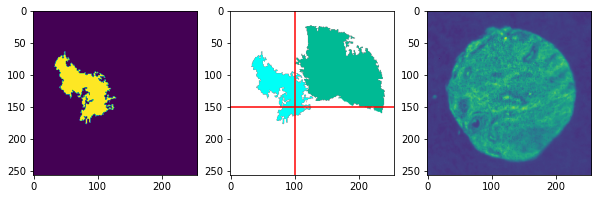

In [8]:
x,y = 100,150

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10,5))

annotation = image.imread(f"/mnt/c/Users/conor/Google Drive/PHD/Project with Janet/Label_Images/TMA_1/TMA_1.1_A5.png")

tumour = annotation[y, x, :]

mask = np.all(annotation == tumour, axis = 2)

ax1.imshow(mask, interpolation=None)
ax2.imshow(annotation)
ax2.axhline(y, c='r')
ax2.axvline(x, c='r')
ax3.imshow(df.values.reshape((256,256,-1))[:,:,np.where(df.columns==1650)[0]])

# Getting metadata

In [2]:
try:metadata = pd.read_excel("/mnt/b/Google_Drive/PhD/Project with Janet/Scoring grids Advancing Front (TMAs 1-3).xlsx", sheet_name = "reformatted")
except:metadata = pd.read_excel("/mnt/c/Users/conor/Google Drive/PhD/Project with Janet/Scoring grids Advancing Front (TMAs 1-3).xlsx", sheet_name = "reformatted")

try:new_metadata = pd.read_excel("/mnt/b/Google_Drive/PhD/Project with Janet/new_metadata.xlsx")
except:new_metadata = pd.read_excel("/mnt/c/Users/conor/Google Drive/PhD/Project with Janet/new_metadata.xlsx")

In [10]:
new_metadata["DODvsAlive"] = new_metadata["OUTCOME"].map(
                            {"DOD" : "DOD",
                             "alive": "Other",
                             "died other" : "Other",
                             "died" : "Other",
                             "Died" : "Other",
                             "Died other": "Other"})

new_metadata["DiedvsAlive"] = new_metadata["OUTCOME"].map(
                            {"DOD" : "Died",
                             "alive": "Alive",
                             "died other" : "Died",
                             "died" : "Died",
                             "Died" : "Died",
                             "Died other": "Died"})

new_metadata["ECS"] = new_metadata["ECS"].map(
                            {"y" : "Y",
                             "Y": "Y",
                             "N" : "N",
                             "n" : "N"})

In [11]:
new_metadata['lifespan'] = new_metadata['Date of death'] - new_metadata['date of diag']
new_metadata["Years"] = new_metadata['Date of death'].dt.year - new_metadata['date of diag'].dt.year

In [12]:
# Did the patient survive beyond n years?
for i in np.arange(0,5,1):
    
    s = (365*i)
    e = (365*(i+2))
    
    new_metadata[f"{i+1}year"] = new_metadata.apply(lambda row: True if s<(row['lifespan']).days<e and row.OUTCOME not in ['Alive',"alive"] else False, axis = 1)

In [13]:
new_metadata[f"1yeardeath"] = new_metadata.apply(lambda row: True if (row['lifespan']).days<365 and row.OUTCOME not in ['Alive',"alive"] else False, axis = 1)

bins = np.arange(0, new_metadata["Years"].max(),2)

new_metadata["2years"] = np.digitize(new_metadata["Years"], bins)

In [14]:
try:asma = pd.read_excel("/mnt/b/Google_Drive/PhD/Project with Janet/ASMA.xlsx", sheet_name = "Sheet3")
except:asma = pd.read_excel("/mnt/c/Users/conor/Google Drive/PhD/Project with Janet/ASMA.xlsx", sheet_name = "Sheet3")

new_metadata = new_metadata.merge(asma, left_on = "Patient_Number", right_on = "Case ID")

In [15]:
join_ = pd.read_excel('./metadata.xlsx')
join_ = new_metadata.merge(join_, left_on='Patient_Number', right_on='Patient_Number')

In [16]:
join_['merge'] = join_.apply(lambda row: row['envi_loc'].split('/')[-1][5:-4], axis=1)

In [17]:
#asma = pd.read_excel("/mnt/b/Google_Drive/PhD/Project with Janet/ASMA.xlsx", sheet_name = "Sheet3")
asma = pd.read_excel("/mnt/c/Users/conor/Google Drive/PhD/Project with Janet/ASMA.xlsx", sheet_name = "Sheet3")

metadata = metadata.merge(asma, left_on = "Patient_nu ", right_on = "Case ID")

metadata['ID'] = metadata.apply(lambda row: f"{row['TMA']}-{row['TMA site']}", axis=1)


metadata[f"1yeardeath"] = metadata.apply(lambda row: True if (row['survival (months)'])<12 and row['Overall Death '] not in ['Alive',"alive"] else False, axis = 1)

In [18]:
joined = total_dict.reset_index().merge(metadata, left_on='ID', right_on='ID')

In [23]:
joined.to_hdf('./Kohler_Raw_Data_1703.hdf', key='Data')

/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/pandas/io/pytables.py:270: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->axis0] [items->None]

  f(store)
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/pandas/io/pytables.py:270: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_items] [items->None]

  f(store)
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/pandas/core/generic.py:2431: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->Index(['ID', 'TMA site', 'gender', 'Patient_nu ', 'Corrected Site AJCC/UICC',
       'Pathogical Stage', 'T stage', 'N stage', 'ECS', 'diff',
       'advancing front type', 'Ove

In [24]:
load = pd.read_hdf('./Kohler_Raw_Data_1703.hdf', key='Data')

In [25]:
load.shape

(273261, 773)